In [ ]:
import sklearn
import cv2
import os
import pickle
import math
import sys
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
!pip install mne
import mne
import pandas as pd
!pip install neupy
import neupy
from sklearn.cluster import KMeans
from neupy import algorithms
import seaborn as sns
from scipy.signal import find_peaks
from mne.utils import logger, verbose
import random

     |████████████████████████████████| 7.0MB 3.2MB/s 
     |████████████████████████████████| 235kB 3.8MB/s 
     |████████████████████████████████| 92.7MB 44kB/s 
     |████████████████████████████████| 368kB 44.6MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 3.2MB 30.5MB/s 
  Found existing installation: progressbar2 3.38.0
    Uninstalling progressbar2-3.38.0:
      Successfully uninstalled progressbar2-3.38.0
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uni

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/s01.dat', 'rb') as file: x = pickle.load(file, encoding='latin1')
data_ = x['data']
eeg_data=data_[:,0:32,:]
print(eeg_data.shape)

(40, 32, 8064)


[3.1462183  4.30571133 3.87961619 ... 3.18765695 4.04046104 4.35953958]


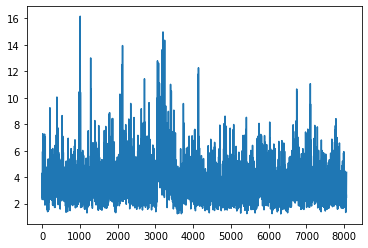

In [ ]:
#gfp calculation
gfp=[]
for video in range(40):
  RMSE_array=[]
  for i in range(len(eeg_data[0][0])):
    v_mean=0
    for j in range(len(eeg_data[0])):
      v_mean=v_mean+eeg_data[video,j,i]
    v_mean=v_mean/len(eeg_data[0])
    squared_error=0
    for j in range(len(eeg_data[0])):
      squared_error=squared_error+(eeg_data[video,j,i]-v_mean)**2
    RMSE=math.sqrt(squared_error/len(eeg_data[0]))
    RMSE_array.append(RMSE)
  #print(len(RMSE_array))
  gfp.append(RMSE_array)
gfp=np.array(gfp)
#print(gfp.shape)
gfp=gfp[0]
gfp=np.transpose(gfp)
print(gfp)
plt.plot([i for i in range(8064)], gfp)

In [ ]:
Fp1,AF3,F3,F7,FC5,FC1,C3,T7,CP5,CP1,P3,P7,PO3,O1,Oz,Pz,Fp2,AF4,Fz,F4,F8,FC6,FC2,Cz,C4,T8,CP6,CP2,P4,P8,PO4,O2 = eeg_data[0][:, 1]
col = ['Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4','F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2']
m = [[0, 0, 0, Fp1, 0, Fp2, 0 , 0, 0],
    [0, 0, 0, AF3, 0, AF4, 0, 0, 0],
    [F7, 0, F3, 0, Fz, 0, F4, 0, F8],
    [0, FC5, 0, FC1, 0, FC2, 0, FC6, 0],
    [T7, 0, C3, 0, Cz, 0, C4, 0, T8],
    [0, CP5, 0, CP1, 0, CP2, 0, CP6, 0],
    [P7, 0, P3, 0, Pz, 0, P4, 0, P8],
    [0, 0, 0, PO3, 0, PO4, 0, 0, 0],
    [0, 0, 0, O1, Oz, O2, 0, 0, 0]]

info = np.array([[i, j] for i in range(9) for j in range(9) if m[i][j] != 0])

In [ ]:
eeg_data=data_[0,0:32,:]

In [ ]:
def _corr_vectors(A, B, axis=0):
    """Compute pairwise correlation of multiple pairs of vectors.
    Fast way to compute correlation of multiple pairs of vectors without
    computing all pairs as would with corr(A,B). Borrowed from Oli at Stack
    overflow. Note the resulting coefficients vary slightly from the ones
    obtained from corr due differences in the order of the calculations.
    (Differences are of a magnitude of 1e-9 to 1e-17 depending of the tested
    data).
    Parameters
    ----------
    A : ndarray, shape (n, m)
        The first collection of vectors
    B : ndarray, shape (n, m)
        The second collection of vectors
    axis : int
        The axis that contains the elements of each vector. Defaults to 0.
    Returns
    -------
    corr : ndarray, shape (m,)
        For each pair of vectors, the correlation between them.
    """
    An = A - np.mean(A, axis=axis)
    Bn = B - np.mean(B, axis=axis)
    An /= np.linalg.norm(An, axis=axis)
    Bn /= np.linalg.norm(Bn, axis=axis)
    return np.sum(An * Bn, axis=axis)

In [ ]:
def plot_maps(maps, info):
    """Plot prototypical microstate maps.
    Parameters
    ----------
    maps : ndarray, shape (n_channels, n_maps)
        The prototypical microstate maps.
    info : instance of mne.io.Info
        The info structure of the dataset, containing the location of the
        sensors.
    """
    for i, map in enumerate(maps):
        plt.figure(figsize=(10,10))
        plt.subplot(1, len(maps), i + 1)
        mne.viz.plot_topomap(map, info)
        #plt.title('%d' % i)

In [ ]:
def locmax(x):
    """Get local maxima of 1D-array
    Args:
        x: numeric sequence
    Returns:
        m: list, 1D-indices of local maxima
    """

    dx = np.diff(x) # discrete 1st derivative
    zc = np.diff(np.sign(dx)) # zero-crossings of dx
    m = 1 + np.where(zc == -2)[0] # indices of local max.
    return m

In [ ]:
peaks = locmax(gfp)
eeg_data1=eeg_data.T
ip_eeg=eeg_data[:,peaks]
ip_eeg1=ip_eeg.T
learn_rate=0.24


minValue = np.amin(ip_eeg)
maxValue=np.amax(ip_eeg)
for op in range(8,11):
  wt=np.random.randint(minValue,maxValue,size=(32,op))
  wt=wt.astype(np.float)

  t=1
  gev=0
  total_epochs=200
  for epochs in range(total_epochs):
    #print("epoch: ",epochs)
    for ele in range(peaks.size):
      d=[]
      for i in range(op):
        temp=0
        for j in range(32):
          temp+=(wt[j][i]-ip_eeg1[ele][j])**2   
        temp=math.sqrt(temp)
        d.append(temp)
      d=np.array(d)
      dmin=np.argmin(d)
      wt1=wt
      sigma_t = 1*math.exp(-1*t/(total_epochs*peaks.size))
      for k in range(32):
        wt1[k][dmin]=wt[k][dmin]+math.sqrt(abs(learn_rate**2 - (t/(total_epochs*peaks.size))**2))*(ip_eeg1[ele][k]-wt[k][dmin])*math.exp(-1*dmin*dmin/(2*(sigma_t*sigma_t)))
      sofm_maps=wt1.T
      t=t+1
      sofm_maps /= np.linalg.norm(sofm_maps, axis=1, keepdims=True) 

      gfp_sum_sq=np.sum(gfp**2)
      activation=sofm_maps.dot(eeg_data)
      seg=np.argmax(np.abs(activation),axis=0)
      map_corr=_corr_vectors(eeg_data,sofm_maps[seg].T)
      gev_sofm=sum((gfp*map_corr)**2)/gfp_sum_sq
      if((gev<gev_sofm)):
        wt=wt1
        gev=gev_sofm    
        seg_final=seg
        maps=sofm_maps
    #print(gev)
  print('')
  print('')
  print("GEV for ",op," clusters: ",gev)
  #plot_maps(maps,info)




GEV for  8  clusters:  0.6177661037883359


GEV for  9  clusters:  0.6119485598248451


GEV for  10  clusters:  0.6111486048100122


In [ ]:
#np.set_printoptions(threshold=sys.maxsize)
#print(seg)